In [39]:
import requests
import torch
import numpy as np
from PIL import Image, ImageOps
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms, datasets
import torchvision
from io import BytesIO
import cv2
import base64

In [2]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [3]:
def load_model(model_path, num_classes):
    model = torchvision.models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [4]:
def leaf_classification(image_crop, model, transform, class_labels):
    # Apply the transformation
    image_tensor = transform(image_crop).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.sigmoid(outputs).numpy().flatten()
        highest_prob = np.max(probs)
        highest_class = class_labels[np.argmax(probs)]
    return highest_class, highest_prob

In [5]:
def to_grayscale(image):
    grayscale_image = image.convert("L")
    grayscale_image = np.stack([np.array(grayscale_image)]*3, axis=-1)
    return Image.fromarray(grayscale_image)

In [6]:
def make_square(image, min_size=224, fill_color=(255, 255, 255)):
    x, y = image.size
    size = max(min_size, x, y)
    new_image = Image.new('RGB', (size, size), fill_color)
    new_image.paste(image, ((size - x) // 2, (size - y) // 2))
    return new_image

In [8]:
def visualize_detection(image, results):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    
    for result in results:
        for box, label, score in zip(result["boxes"], result["labels"], result["scores"]):
            box = box.cpu().numpy()
            x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
            
            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            # Annotate with the label and score
            plt.text(x1, y1, f'{label}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.axis('off')
    plt.show()

In [34]:
def boost_confidence(confidence, boost_factor=0.3):
    return min(confidence + boost_factor, 1.0)

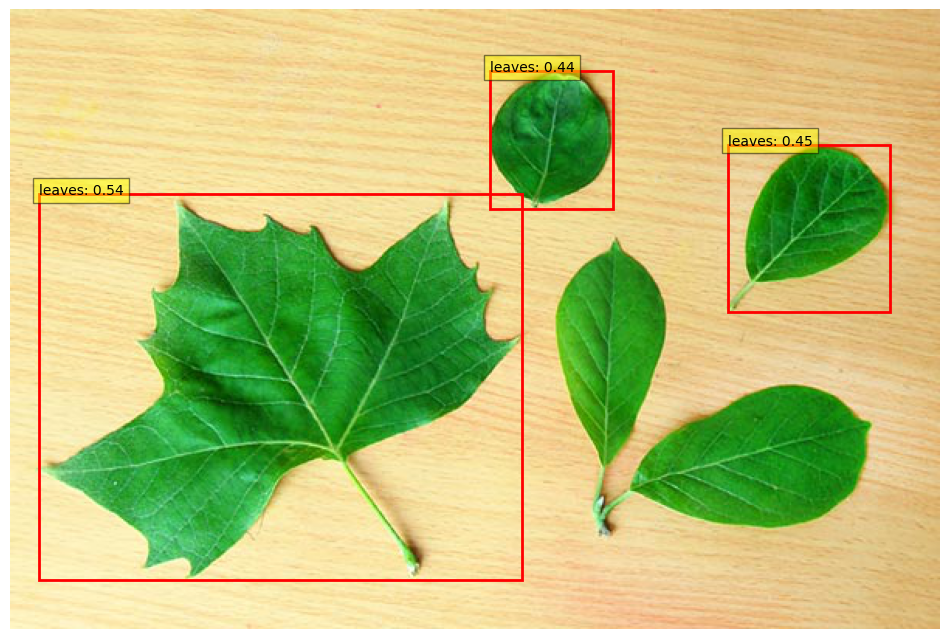

Detected leaves with score 0.54. Classified as Palo Maria with confidence 1.00


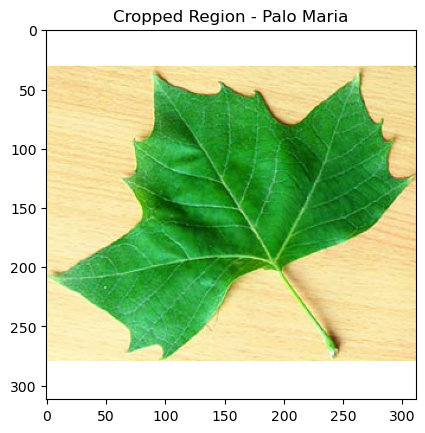

Detected leaves with score 0.45. Classified as Palo Maria with confidence 0.69


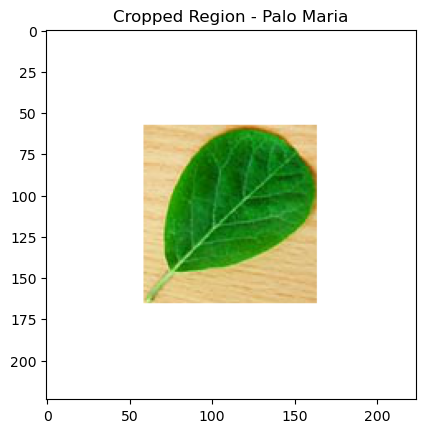

Detected leaves with score 0.44. Classified as Apitong with confidence 0.76


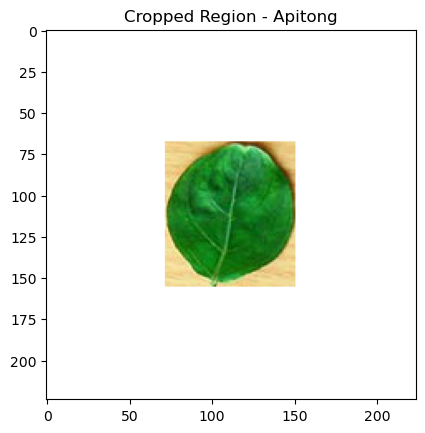

In [46]:
if __name__ == "__main__":
    model_id = "IDEA-Research/grounding-dino-tiny"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

    model_path = 'final_model.pth'
    class_labels = ['Apitong', 'Balete', 'Bayabas', 'Guyabano', 'Kamagong', 'Langka', 'Mahogany', 'Mangga', 'Palo Maria']
    leaf_model = load_model(model_path, num_classes=len(class_labels)).to(device)
    leaf_model.eval()  
    data_transforms = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.Lambda(to_grayscale),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # image_path = r"C:\Users\faith\Documents\Snapfolia - CS\Samples\Leaf_Samples\Balete\Balete A (1).jpg"
    # image = Image.open(image_path).convert('RGB')
    
    image_url = 'https://www.firstpalette.com/images/craft-steps/leafprints-step1.jpg'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    
    inputs = processor(images=image, text="a leaf. leaves.", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )

    if results and "boxes" in results[0] and results[0]["boxes"].shape[0] > 0:
        visualize_detection(image, results)

        for result in results:
            for box, label, score in zip(result["boxes"], result["labels"], result["scores"]):
                box = box.cpu().numpy()
                x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
                cropped_image = image.crop((x1, y1, x2, y2))
                
                # Make the cropped image square with padding
                cropped_image_square = make_square(cropped_image)

                cropped_image_transformed = data_transforms(cropped_image_square).unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = leaf_model(cropped_image_transformed)
                confidence, predicted_class = torch.max(torch.nn.functional.softmax(logits, dim=1), dim=1)
                leaf_type = class_labels[predicted_class.item()]
                confidence = boost_confidence(confidence.item())
                
                print(f"Detected {label} with score {score:.2f}. Classified as {leaf_type} with confidence {confidence:.2f}")

                # Visualize the cropped region
                plt.figure()
                plt.imshow(cropped_image_square)
                plt.title(f"Cropped Region - {leaf_type}")
                plt.axis('on')
                plt.show()
    else:
        plt.figure()
        plt.imshow(image)
        plt.title("Original Image - No Leaf detected")
        plt.axis('on')
        plt.show()